# 19 Convolutional Neural Networks in Pytorch Copy

If you are planning to use `pytorch` on the workstations installed in the Department of Computer Science, you must execute this command

`export PYTHONPATH=$PYTHONPATH:/usr/local/anaconda/lib/python3.6/site-packages/`

A better solution is to add it to your startup script, such as `.bashrc`.

In [1]:
# Modified from https://github.com/vinhkhuc/PyTorch-Mini-Tutorials

import numpy as np

import torch
from torch.autograd import Variable

import time

import gzip
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class ConvNet(torch.nn.Module):
    def __init__(self, output_dim, relu=True):
        super().__init__()

        self.activation = torch.relu if relu else torch.tanh
        
        self.conv_1 = torch.nn.Conv2d(1, 10, kernel_size=5, stride=1)
        self.conv_2 = torch.nn.Conv2d(10, 20, kernel_size=5, stride=2)

        # Calculate number of inputs to next linear layer. Result of
        # flattening the outputs from the second convolutional layer
        image_hw = 28
        kernel = 5
        stride = 1
        conv_1_hw = (image_hw - kernel) // stride + 1
        kernel = 5
        stride = 2
        n_units = 20
        conv_2_hw = (conv_1_hw - kernel) // stride + 1
        n_inputs = conv_2_hw ** 2 * n_units

        self.fc_1 = torch.nn.Linear(n_inputs, 20)
        self.fc_2 = torch.nn.Linear(20, output_dim)

    def forward_all_outputs(self, x):
        n_samples = x.shape[0]
        Y_conv_1 = self.activation(self.conv_1(x))
        Y_conv_2 = self.activation(self.conv_2(Y_conv_1))

        Y_fc_1 = self.activation(self.fc_1(Y_conv_2.reshape(n_samples, -1)))
        Y = self.fc_2(Y_fc_1)
        return Y_conv_1, Y_conv_2, Y_fc_1, Y

    def forward(self, x):
        Y_each_layer = self.forward_all_outputs(x)
        return Y_each_layer[-1]
    
    def train(self, Xtrain, Ttrain, Xtest, n_epochs, batch_size, learning_rate):
        
        start_time = time.time()

        loss = torch.nn.CrossEntropyLoss(reduction='mean')
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        # optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        n_examples = Xtrain.shape[0]
        for i in range(n_epochs):
            cost = 0.
            num_batches = n_examples // batch_size
            for k in range(num_batches):
                start, end = k * batch_size, (k + 1) * batch_size
                Xtrain_batch = Xtrain[start:end, ...]  # rather than typing, [start:end, :, :, :]
                Ttrain_batch = Ttrain[start:end, ...]
                Xtrain_batch = Variable(Xtrain_batch, requires_grad=False)
                Ttrain_batch = Variable(Ttrain_batch, requires_grad=False)

                # Reset gradient
                optimizer.zero_grad()

                # Forward
                Y = self.forward(Xtrain_batch)
                output = loss.forward(Y, Ttrain_batch)

                # Backward
                output.backward()

                # Update parameters
                optimizer.step()

                cost += output.item()
                
            Ytest = self.forward(Xtest)
            Ytest_class = Ytest.data.cpu().numpy().argmax(axis=1)
            print('Epoch {:d}, cost = {:.4f}, acc = {:.2f}'.format(i + 1, cost / num_batches, 100. * np.mean(Ytest_class == Ttest)))

        print('Took {:.2f} seconds'.format(time.time() - start_time))

In [3]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [4]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape((-1, 1, 28, 28))
Ttrain = train_set[1] 
Xtest = test_set[0].reshape((-1, 1, 28, 28))
Ttest = test_set[1] 

Xtrain = torch.from_numpy(Xtrain).float().to(device)
Xtest = torch.from_numpy(Xtest).float().to(device)
Ttrain = torch.from_numpy(Ttrain).long().to(device)
# Do not need Ttest as torch.Tensor because it is only used in numpy calculation

In [5]:
n_classes = 10
# nnet = ConvNet(output_dim=n_classes)
# nnet.to(device)
n_epochs = 40
batch_size = 100
learning_rate = 0.001
# nnet.train(Xtrain, Ttrain, Xtest, n_epochs, batch_size, learning_rate)\
# load the trained classifier
nnet = pickle.load(open('CNN_trained.sav', 'rb'))

In [6]:
x = Xtest[20:21]
conv1, conv2, fc1, fc2 = nnet.forward_all_outputs(x)
layer1weights = list(nnet.children())[0].weight.data

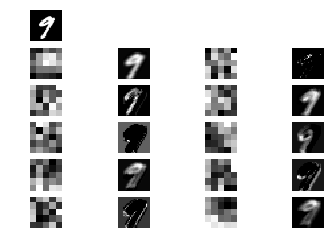

In [7]:
plt.subplot(6, 4, 1)
plt.imshow(x.squeeze().cpu(), cmap='gray')
plt.axis('off')

ploti = 4
for i in range(10):
    ploti += 1
    plt.subplot(6, 4, ploti)
    plt.imshow(layer1weights[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(6, 4, ploti)
    plt.imshow(conv1[0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

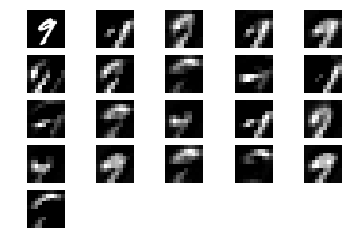

In [8]:
layer2weights = list(nnet.children())[1].weight.data

plt.subplot(5, 5, 1)
plt.imshow(x.squeeze().cpu(), cmap='gray')
plt.axis('off')

ploti = 1
for i in range(20):
    ploti += 1
    plt.subplot(5, 5, ploti)
    plt.imshow(conv2[0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

In [9]:
x = Xtest[0:10]
conv1, conv2, fc1, fc2 = nnet.forward_all_outputs(x)
print(fc2.shape)

torch.Size([10, 10])


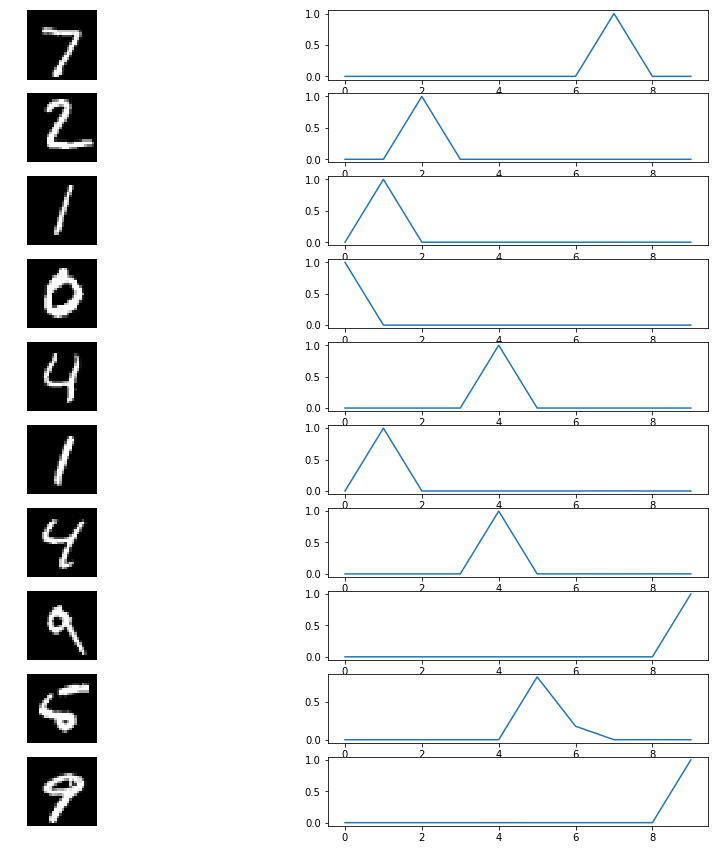

In [10]:
plt.figure(figsize=(15, 15))
ploti = 0
for i in range(10):
    ploti += 1
    plt.subplot(10, 2, ploti)
    plt.imshow(x[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 2, ploti)
    # Try calculating this my self
    Y = fc2[i, :].cpu().detach().numpy()
    Yprobs = np.exp(Y) / np.sum(np.exp(Y))
    plt.plot(Yprobs)